In [1]:

# Most straight-forward way to import a librayr in Python
import requests

# BeautifulSoup is a module inside the "bs4" library, we only import the BeautifulSoup module
from bs4 import BeautifulSoup

# We import pandas but give the library a shortcut alias "pd" since we will call its functions so much
import pandas as pd


In [2]:

# Make the request
steam_pbg = requests.get('https://steamcharts.com/app/578080').text

# Turn into soup, specify the HTML parser
steam_pbg_soup = BeautifulSoup(steam_pbg,'html.parser')

# Use .find_all to retrieve all the tables in the page
steam_pbg_tables = steam_pbg_soup.find_all('table')

In [3]:
steam_pbg_tables[0]

<table class="common-table">
<thead>
<tr>
<th class="left">Month</th>
<th class="right">Avg. Players</th>
<th class="right">Gain</th>
<th class="right">% Gain</th>
<th class="right">Peak Players</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td class="month-cell left italic">Last 30 Days</td>
<td class="right num-f italic">304808.29</td>
<td class="right num-p gainorloss italic">-444.9</td>
<td class="right gainorloss italic">-0.15%</td>
<td class="right num italic">804674</td>
</tr>
<tr>
<td class="month-cell left">
					May 2025
				</td>
<td class="right num-f">305253.18</td>
<td class="right num-p gainorloss">-12187.85</td>
<td class="right gainorloss">-3.84%</td>
<td class="right num">804674</td>
</tr>
<tr class="odd">
<td class="month-cell left">
					April 2025
				</td>
<td class="right num-f">317441.03</td>
<td class="right num-p gainorloss">-28086.31</td>
<td class="right gainorloss">-8.13%</td>
<td class="right num">861598</td>
</tr>
<tr>
<td class="month-cell left">
					Mar

In [4]:
# Scrape the three game data together

import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

# Define URLs and game names
game_urls = {
    "CS2": "https://steamcharts.com/app/730",
    "Dota 2": "https://steamcharts.com/app/570",
    "PUBG": "https://steamcharts.com/app/578080"
}

# List to hold all game DataFrames
all_game_data = []

for game_name, url in game_urls.items():
    # Request and parse the HTML page
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Find all tables
    tables = soup.find_all("table")
    if len(tables) == 0:
        print(f"No table found for {game_name}")
        continue
    
    # Convert table to DataFrame
    table_html = str(tables[0])  # SteamCharts only has one table
    df = pd.read_html(table_html)[0]
    df["Game"] = game_name  # Add Game column

    # Clean up numeric columns (handle "-" entries)
    df["Avg. Players"] = df["Avg. Players"].astype(str).str.replace(",", "").replace("-", np.nan).astype(float)
    df["Gain"] = df["Gain"].astype(str).str.replace(",", "").replace("-", np.nan).astype(float)
    df["% Gain"] = df["% Gain"].astype(str).str.replace("%", "").replace("-", np.nan).astype(float)
    df["Peak Players"] = df["Peak Players"].astype(str).str.replace(",", "").replace("-", np.nan).astype(float)

    # Append to list
    all_game_data.append(df)

# Combine all into one DataFrame
combined_df = pd.concat(all_game_data, ignore_index=True)

# Preview result
print(combined_df.head())






           Month  Avg. Players      Gain  % Gain  Peak Players Game
0   Last 30 Days    1031410.81  -7186.00   -0.69     1712216.0  CS2
1       May 2025    1038596.81  -7104.84   -0.68     1712216.0  CS2
2     April 2025    1045701.65   6038.84    0.58     1811827.0  CS2
3     March 2025    1039662.81  36092.25    3.60     1818368.0  CS2
4  February 2025    1003570.56  89478.34    9.79     1783434.0  CS2


In [5]:
# save as csv
combined_df.to_csv("steamcharts_combined3.csv", index=False)

In [6]:

# Load the full scraped data
df = pd.read_csv("steamcharts_combined3.csv")

# Remove non-month labels like "Last 30 Days"
df = df[df["Month"].str.contains(r"\d{4}$")].copy()

# Convert to datetime
df["Month"] = pd.to_datetime(df["Month"], format="%B %Y")

# Sort and compute gain within each game
df = df.sort_values(["Game", "Month"])
df["Prev Avg. Players"] = df.groupby("Game")["Avg. Players"].shift(1)
df["Gain"] = df["Avg. Players"] - df["Prev Avg. Players"]
df["% Gain"] = (df["Gain"] / df["Prev Avg. Players"]) * 100

# First row per game has NaN gain and fill with 0
df["Gain"] = df["Gain"].fillna(0)
df["% Gain"] = df["% Gain"].fillna(0)

# Drop helper column
df = df.drop(columns=["Prev Avg. Players"])

# Save full-range result (per-game)
df.to_csv("steamcharts_clean_full.csv", index=False)








In [7]:
# Make three separate data frame since I am trying to make time series models separately for the three games

df = pd.read_csv("steamcharts_clean_full.csv")

#  Ensure 'Month' is in datetime format 
df["Month"] = pd.to_datetime(df["Month"])

# Split into three subsets
df_cs2 = df[df["Game"] == "CS2"].reset_index(drop=True)
df_pubg = df[df["Game"] == "PUBG"].reset_index(drop=True)
df_dota2 = df[df["Game"] == "Dota 2"].reset_index(drop=True)

# Step 4: Save each to its own CSV file
df_cs2.to_csv("cs2_data.csv", index=False)
df_pubg.to_csv("pubg_data.csv", index=False)
df_dota2.to_csv("dota2_data.csv", index=False)




In [12]:
# Add patch counts variable

from datetime import datetime
from collections import defaultdict

# Game name to AppID mapping
appid_map = {
    "CS2": 730,
    "PUBG": 578080,
    "Dota 2": 570
}

def get_patch_counts(appid):
    """Fetch and count patch/update news items per month from Steam API"""
    url = f"https://api.steampowered.com/ISteamNews/GetNewsForApp/v2/?appid={appid}&count=300&maxlength=1"
    r = requests.get(url)
    items = r.json().get("appnews", {}).get("newsitems", [])
    
    patch_per_month = defaultdict(int)
    for item in items:
        title = item.get("title", "").lower()
        if "patch" in title or "update" in title:
            month = datetime.utcfromtimestamp(item["date"]).strftime("%Y-%m")
            patch_per_month[month] += 1
    
    return patch_per_month

def add_patch_counts(file_name, game_name):
    df = pd.read_csv(file_name)
    df["Month"] = pd.to_datetime(df["Month"]).dt.strftime("%Y-%m")
    
    patch_dict = get_patch_counts(appid_map[game_name])
    df["Patch_Count"] = df["Month"].map(patch_dict).fillna(0).astype(int)
    
    out_file = f"{game_name.lower()}_with_patch.csv"
    df.to_csv(out_file, index=False)
    

add_patch_counts("cs2_data.csv", "CS2")
add_patch_counts("pubg_data.csv", "PUBG")
add_patch_counts("dota2_data.csv", "Dota 2")

In [ ]:
from pytrends.request import TrendReq
import pandas as pd
import time

# Define the correct timeframe for each game
timeframes = {
    "CS2": ("Counter-Strike", "2012-07-01 2025-05-01"),
    "Dota 2": ("Dota 2", "2012-07-01 2025-05-01"),
    "PUBG": ("PUBG", "2017-03-01 2025-05-01")
}

# Initialize pytrends
pytrends = TrendReq(hl='en-US', tz=360)
trend_data_list = []

for game, (keyword, timeframe) in timeframes.items():
    print(f"Fetching trends for {game} using keyword '{keyword}' from {timeframe}")
    try:
        pytrends.build_payload([keyword], timeframe=timeframe)
        data = pytrends.interest_over_time()
        time.sleep(2)  # To avoid 429 errors

        if not data.empty:
            df_monthly = data.resample('MS').mean()
            df_monthly = df_monthly.reset_index()[['date', keyword]]
            df_monthly.columns = ['Month', 'Google_Trends_Index']
            df_monthly['Game'] = game
            trend_data_list.append(df_monthly)
            print(f" Done: {game}")
        else:
            print(f" Empty trends for {game}")
    except Exception as e:
        print(f" Error for {game}: {e}")

# Combine all Google Trend data
df_trends = pd.concat(trend_data_list, ignore_index=True)
df_trends.to_csv("google_trends_by_game.csv", index=False)
print(" Saved Google Trends to google_trends_by_game.csv")




Fetching trends for CS2 using keyword 'Counter-Strike' from 2012-07-01 2025-05-01
✅ Done: CS2
Fetching trends for Dota 2 using keyword 'Dota 2' from 2012-07-01 2025-05-01
✅ Done: Dota 2
Fetching trends for PUBG using keyword 'PUBG' from 2017-03-01 2025-05-01
✅ Done: PUBG
✅ Saved Google Trends to google_trends_by_game.csv


In [ ]:


# Step 1: Load patch data
df_cs2 = pd.read_csv("cs2_with_patch.csv")
df_pubg = pd.read_csv("pubg_with_patch.csv")
df_dota2 = pd.read_csv("dota 2_with_patch.csv")

# Step 2: Load Google Trends data
df_trends = pd.read_csv("google_trends_by_game.csv")

# Step 3: Ensure 'Month' column is datetime in all files
df_cs2["Month"] = pd.to_datetime(df_cs2["Month"])
df_pubg["Month"] = pd.to_datetime(df_pubg["Month"])
df_dota2["Month"] = pd.to_datetime(df_dota2["Month"])
df_trends["Month"] = pd.to_datetime(df_trends["Month"])

# Step 4: Filter and merge trends for each game
cs2_trend = df_trends[df_trends["Game"] == "CS2"].drop(columns="Game")
pubg_trend = df_trends[df_trends["Game"] == "PUBG"].drop(columns="Game")
dota2_trend = df_trends[df_trends["Game"] == "Dota 2"].drop(columns="Game")

df_cs2 = df_cs2.merge(cs2_trend, on="Month", how="left")
df_pubg = df_pubg.merge(pubg_trend, on="Month", how="left")
df_dota2 = df_dota2.merge(dota2_trend, on="Month", how="left")

# Step 5: Save the final merged datasets
df_cs2.to_csv("cs2_with_patch_trend.csv", index=False)
df_pubg.to_csv("pubg_with_patch_trend.csv", index=False)
df_dota2.to_csv("dota2_with_patch_trend.csv", index=False)

print("Merged Google Trends Index into all patch datasets successfully.")





✅ Merged Google Trends Index into all patch datasets successfully.


EDA

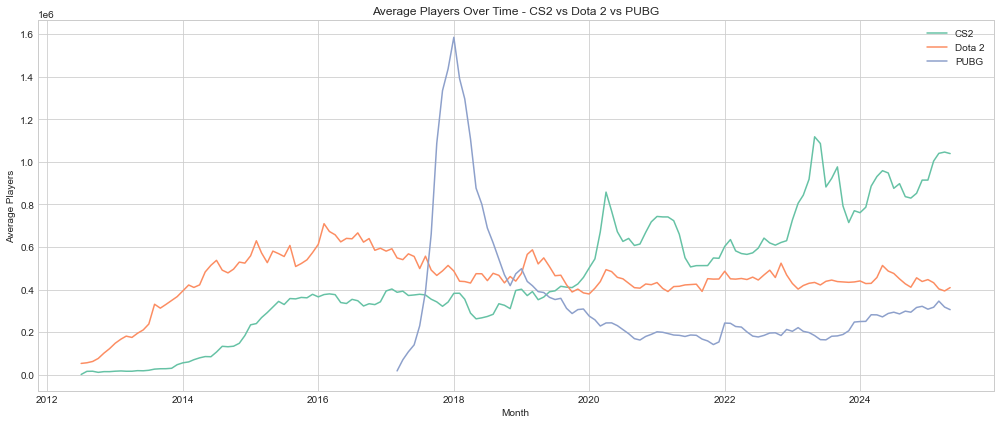

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSVs
df_cs2 = pd.read_csv("cs2_with_patch_trend.csv")
df_dota2 = pd.read_csv("dota2_with_patch_trend.csv")
df_pubg = pd.read_csv("pubg_with_patch_trend.csv")

# Convert 'Month' to datetime and add Game labels
df_cs2["Month"] = pd.to_datetime(df_cs2["Month"])
df_dota2["Month"] = pd.to_datetime(df_dota2["Month"])
df_pubg["Month"] = pd.to_datetime(df_pubg["Month"])
df_cs2["Game"] = "CS2"
df_dota2["Game"] = "Dota 2"
df_pubg["Game"] = "PUBG"

# Combine and re-confirm datetime
df_all = pd.concat([df_cs2, df_dota2, df_pubg], ignore_index=True)
df_all["Month"] = pd.to_datetime(df_all["Month"])
df_all["Avg. Players"] = pd.to_numeric(df_all["Avg. Players"], errors="coerce")  # just in case

# Plot
plt.figure(figsize=(14, 6))
for game in df_all["Game"].unique():
    df_game = df_all[df_all["Game"] == game].sort_values("Month")
    plt.plot(df_game["Month"].values, df_game["Avg. Players"].values, label=game)  # <- use .values to ensure 1D

plt.title("Average Players Over Time - CS2 vs Dota 2 vs PUBG")
plt.xlabel("Month")
plt.ylabel("Average Players")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




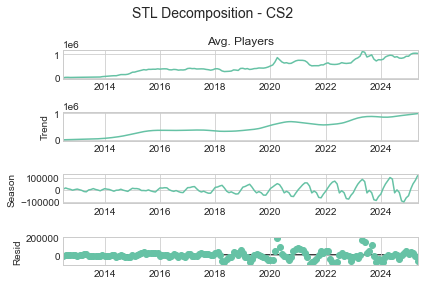

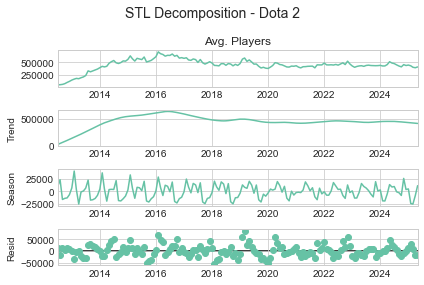

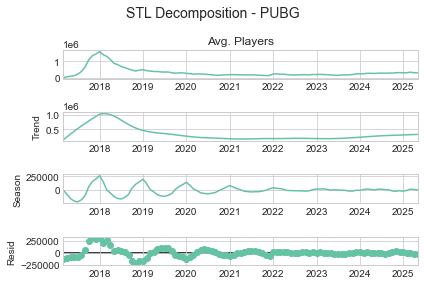

In [31]:

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# Ensure Month is datetime and Avg. Players is numeric
df_all["Month"] = pd.to_datetime(df_all["Month"])
df_all["Avg. Players"] = pd.to_numeric(df_all["Avg. Players"], errors="coerce")
df_all = df_all.sort_values(["Game", "Month"])

# Set Month as index (required for time series decomposition)
df_all.set_index("Month", inplace=True)

# Function to apply STL and plot components
def stl_decompose_plot(game_name):
    df_game = df_all[df_all["Game"] == game_name]["Avg. Players"].dropna()
    df_game = df_game.asfreq('MS')  # Ensure monthly frequency
    stl = STL(df_game, seasonal=13)  # 12 or 13 is typical for monthly data
    result = stl.fit()
    
    # Plotting
    fig = result.plot()
    fig.suptitle(f"STL Decomposition - {game_name}", fontsize=14)
    fig.tight_layout()
    plt.show()

# Run STL for each game
stl_decompose_plot("CS2")
stl_decompose_plot("Dota 2")
stl_decompose_plot("PUBG")






02:16:59 - cmdstanpy - INFO - Chain [1] start processing
02:16:59 - cmdstanpy - INFO - Chain [1] done processing


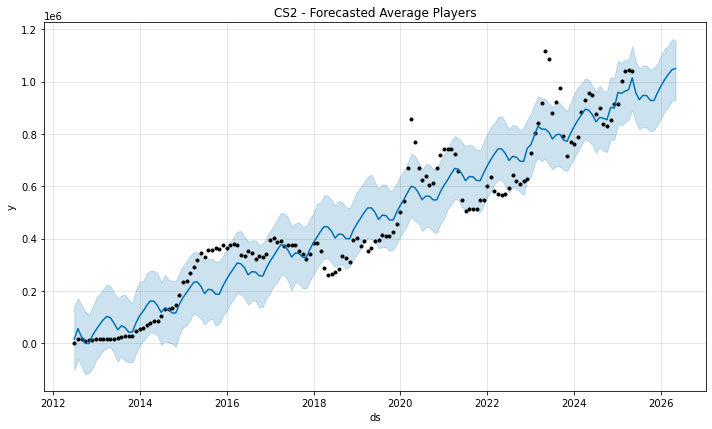

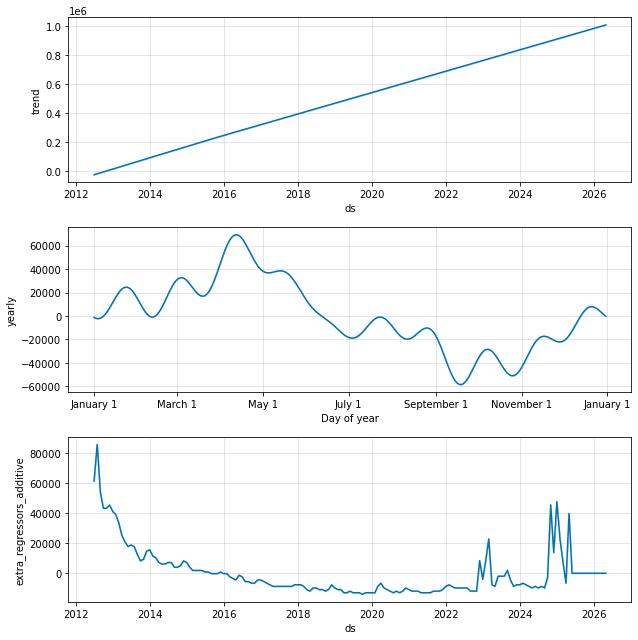

In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load dataset
df_cs2 = pd.read_csv("cs2_with_patch_trend.csv")

# Preprocess data
df_cs2["Month"] = pd.to_datetime(df_cs2["Month"])
df_prophet = df_cs2[["Month", "Avg. Players", "Patch_Count", "Google_Trends_Index"]].copy()
df_prophet.rename(columns={"Month": "ds", "Avg. Players": "y"}, inplace=True)

# Initialize and configure the model
model = Prophet()
model.add_regressor("Patch_Count")
model.add_regressor("Google_Trends_Index")

# Fit the model
model.fit(df_prophet)

# Create future dataframe with extra months and avg values for regressors
future = model.make_future_dataframe(periods=12, freq='M')
future["Patch_Count"] = df_prophet["Patch_Count"].tolist() + [df_prophet["Patch_Count"].mean()] * 12
future["Google_Trends_Index"] = df_prophet["Google_Trends_Index"].tolist() + [df_prophet["Google_Trends_Index"].mean()] * 12

# Forecast
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("CS2 - Forecasted Average Players")
plt.show()

# Plot forecast components
model.plot_components(forecast)
plt.show()


